<a href="https://colab.research.google.com/github/LxMera/Convolutional-Neural-Network-for-the-classification-of-independent-components-of-rs-fMRI/blob/master/CNN_firt_group_(Respaldo)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [1]:
import os
import cv2
import sys
import glob
import random
import warnings
import numpy as np
import pandas as pd
import scipy.io as sio
import tensorflow as tf
from itertools import chain
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imread, imshow, imread_collection, concatenate_images

### Accesses to data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Directory

In [3]:
os.system('cp drive/My\ Drive/HumanProyec2/1HCP_hp2000/TimeF.mat Time.mat')
os.system('cp drive/My\ Drive/HumanProyec2/1HCP_hp2000/OrderF.mat Order.mat')
os.system('cp drive/My\ Drive/HumanProyec2/1HCP_hp2000/LabelsF.mat Labels.mat')
os.system('cp drive/My\ Drive/HumanProyec3/HumanProyec1.zip HumanProyec1.zip')
os.system('cp drive/My\ Drive/HumanProyec3/HumanProyec2.zip HumanProyec2.zip')
os.system('cp drive/My\ Drive/HumanProyec3/HumanProyec3.zip HumanProyec3.zip')
os.system('cp drive/My\ Drive/HumanProyec3/HumanProyec4.zip HumanProyec4.zip')
os.system('cp drive/My\ Drive/HumanProyec3/HumanProyec5.zip HumanProyec5.zip')

0

In [4]:
os.system('unzip HumanProyec1.zip'), os.system('rm -r HumanProyec1.zip')
os.system('unzip HumanProyec2.zip'), os.system('rm -r HumanProyec2.zip')
os.system('unzip HumanProyec3.zip'), os.system('rm -r HumanProyec3.zip')
os.system('unzip HumanProyec4.zip'), os.system('rm -r HumanProyec4.zip')
os.system('unzip HumanProyec5.zip'), os.system('rm -r HumanProyec5.zip')

(0, 0)

In [72]:
FOLD=glob.glob('HCP_hp2000/*')
DATA=glob.glob('*.mat')

print(FOLD)
print(DATA[-1])

['HCP_hp2000/C_AXI', 'HCP_hp2000/C_BLU', 'HCP_hp2000/BLU', 'HCP_hp2000/AXI', 'HCP_hp2000/PCA', 'HCP_hp2000/COM', 'HCP_hp2000/C_PCA', 'HCP_hp2000/C_COM']
Order.mat


In [73]:
label=sio.loadmat('Labels.mat')['labels'][0]
order=sio.loadmat('Order.mat')['order']
timeS=sio.loadmat('Time.mat')['series']

print('Labels per component     \t', np.shape(label))
print('Order of images          \t', np.shape(order))
print('Points time per component\t', np.shape(timeS))

Labels per component     	 (22877,)
Order of images          	 (22877,)
Points time per component	 (1200, 22877)


### Images parameters

In [0]:
DIR='drive/My Drive/ResultadosHP'
slic=['/Axial','/Coronal','/Saggital']

#Original shape
SAG=73
COR=91
AXI=77

#SAG=57
#COR=73
#AXI=57

IMG_CHANNELS = 3
nb_classes=2
maxR=0.4
shap={'Axial': (SAG, COR, IMG_CHANNELS), 'Coronal': (SAG, AXI, IMG_CHANNELS), 'Saggital': (AXI, COR, IMG_CHANNELS)}

### Training and test data

In [75]:
per=0.8
per=int(np.shape(label)[0]*0.8)

TEST_PATH=order[per:]
TRAIN_PATH=order[:per]

y_test =label[per:]
y_train=label[:per]

print('training labels ', y_train.shape)
print('test labels     ', y_test.shape)

print('training maps   ', TRAIN_PATH.shape)
print('test maps       ', TEST_PATH.shape)

training labels  (18301,)
test labels      (4576,)
training maps    (18301,)
test maps        (4576,)


In [0]:
def showSlices(ima1, ima2, ima3):
  plt.figure(figsize=(20,5))
  plt.subplot(1,3,1)
  plt.imshow(ima1)
  plt.title('Saggital')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(ima2)
  plt.title('Coronal')
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(ima3)
  plt.title('Axial')
  plt.axis('off')

  print('Saggital shape ', np.shape(ima1))
  print('Coronal shape ', np.shape(ima2))
  print('Axial shape ', np.shape(ima3))

### Training images

In [77]:
S_train = np.zeros((len(TRAIN_PATH), AXI, COR, 3), dtype=np.uint8)
C_train = np.zeros((len(TRAIN_PATH), SAG, AXI, 3), dtype=np.uint8)
A_train = np.zeros((len(TRAIN_PATH), SAG, COR, 3), dtype=np.uint8)

cont=0
loop=len(TRAIN_PATH)
ni=1 #number of folder
print(FOLD[ni][11:])

for n in range(loop):  
  namea=FOLD[ni]+slic[0]+'/'+TRAIN_PATH[n].strip()+'.png'
  namec=FOLD[ni]+slic[1]+'/'+TRAIN_PATH[n].strip()+'.png'
  names=FOLD[ni]+slic[2]+'/'+TRAIN_PATH[n].strip()+'.png'
  
  imaa=cv2.imread(namea)
  imac=cv2.imread(namec)
  imas=cv2.imread(names)

  sag=cv2.resize(imas, (AXI, COR), interpolation = cv2.INTER_AREA)
  cor=cv2.resize(imac, (AXI, SAG), interpolation = cv2.INTER_AREA)
  axi=cv2.resize(imaa, (COR, SAG), interpolation = cv2.INTER_AREA)

  S_train[n]=np.rot90(sag)
  C_train[n]=cor
  A_train[n]=axi

  cont=cont+1
  print('\rProcess ', round(cont*100/loop,2), '%...' , end ="")

C_BLU
Process  100.0 %...

### Sample images (training)

Saggital shape  (77, 91, 3)
Coronal shape  (73, 77, 3)
Axial shape  (73, 91, 3)
Saggital shape  (77, 91, 3)
Coronal shape  (73, 77, 3)
Axial shape  (73, 91, 3)


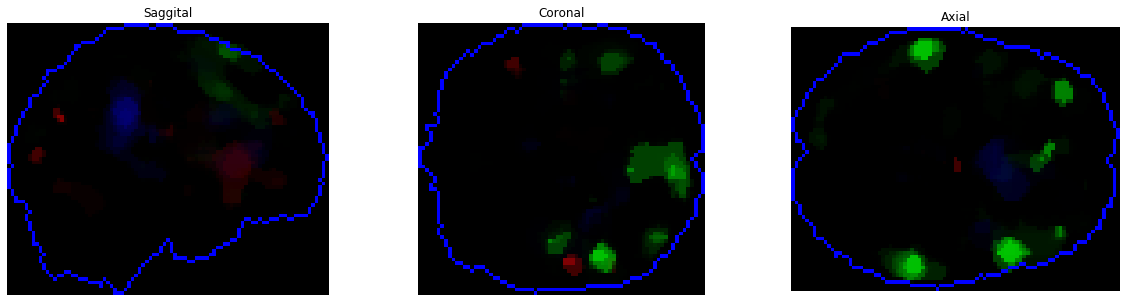

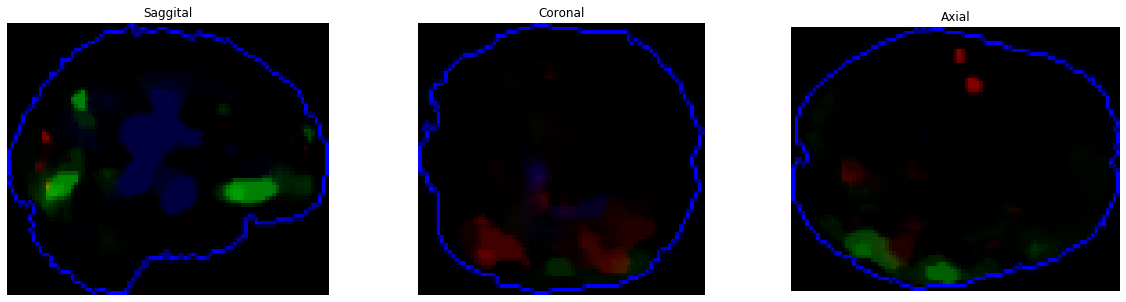

In [78]:
signal=np.random.choice(np.where(y_train==1)[0])
noise=np.random.choice(np.where(y_train==0)[0])
showSlices(S_train[signal], C_train[signal], A_train[signal])
showSlices(S_train[noise], C_train[noise], A_train[noise])

### Test images

In [79]:
S_test = np.zeros((len(TEST_PATH), AXI, COR, 3), dtype=np.uint8)
C_test = np.zeros((len(TEST_PATH), SAG, AXI, 3), dtype=np.uint8)
A_test = np.zeros((len(TEST_PATH), SAG, COR, 3), dtype=np.uint8)

cont=0
loop=len(TEST_PATH)

for n in range(loop):  
  namea=FOLD[ni]+slic[0]+'/'+TEST_PATH[n].strip()+'.png'
  namec=FOLD[ni]+slic[1]+'/'+TEST_PATH[n].strip()+'.png'
  names=FOLD[ni]+slic[2]+'/'+TEST_PATH[n].strip()+'.png'
  
  imaa=cv2.imread(namea)
  imac=cv2.imread(namec)
  imas=cv2.imread(names)

  sag=cv2.resize(imas, (AXI, COR), interpolation = cv2.INTER_AREA)
  cor=cv2.resize(imac, (AXI, SAG), interpolation = cv2.INTER_AREA)
  axi=cv2.resize(imaa, (COR, SAG), interpolation = cv2.INTER_AREA)

  S_test[n]=np.rot90(sag)
  C_test[n]=cor
  A_test[n]=axi

  cont=cont+1
  print('\rProcess ', round(cont*100/loop,2), '%...' , end ="")

Process  100.0 %...

### sample images (test)

Saggital shape  (77, 91, 3)
Coronal shape  (73, 77, 3)
Axial shape  (73, 91, 3)
Saggital shape  (77, 91, 3)
Coronal shape  (73, 77, 3)
Axial shape  (73, 91, 3)


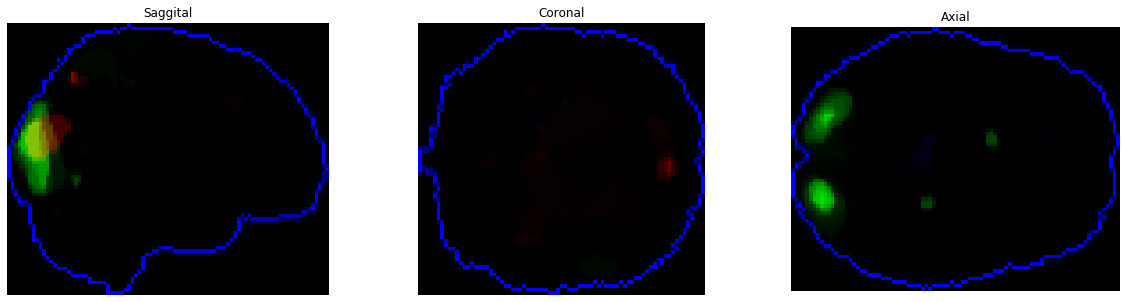

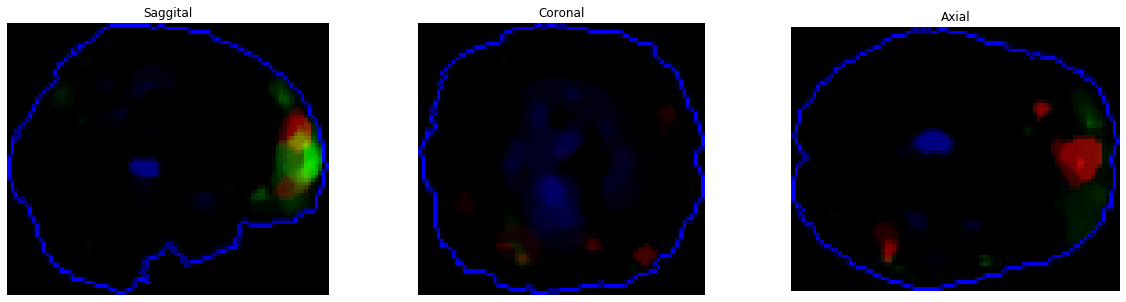

In [80]:
signal=np.random.choice(np.where(y_test==1)[0])
noise=np.random.choice(np.where(y_test==0)[0])
showSlices(S_test[signal], C_test[signal], A_test[signal])
showSlices(S_test[noise], C_test[noise], A_test[noise])

In [0]:
def get_model_1(Slic):

    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(maxR) (c1)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = MaxPooling2D((2, 2)) (c1)    
    
    #Flatten layers
    c6 = Flatten()(c1)
        
    c6 = Dense(16, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)   

    c6 = Dense(8, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)  

    c6 = Dense(4, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)    
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [0]:
def get_Layer_1(Slic):
    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)    
    c1 = Dropout(maxR) (c1) 
    
    #Flatten layers
    c6 = Flatten()(c1)
        
    c6 = Dense(128, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)       
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [0]:
def get_Layer_2(Slic):
    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)    
    c1 = Dropout(maxR) (c1)

    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c2 = MaxPooling2D((2, 2)) (c2)    
    c2 = Dropout(maxR) (c2)
    
    #Flatten layers
    c6 = Flatten()(c2)
        
    c6 = Dense(128, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)       
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [0]:
def get_Layer_3(Slic):
    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)    
    c1 = Dropout(maxR) (c1)

    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c2 = MaxPooling2D((2, 2)) (c2)    
    c2 = Dropout(maxR) (c2)

    c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    c3 = MaxPooling2D((2, 2)) (c3)    
    c3 = Dropout(maxR) (c3)
    
    #Flatten layers
    c6 = Flatten()(c3)
        
    c6 = Dense(128, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)       
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [0]:
def get_Layer_4(Slic):
    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)    
    c1 = Dropout(maxR) (c1) 

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c2 = MaxPooling2D((2, 2)) (c2)    
    c2 = Dropout(maxR) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    c3 = MaxPooling2D((2, 2)) (c3)    
    c3 = Dropout(maxR) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    c4 = MaxPooling2D((2, 2)) (c4)    
    c4 = Dropout(maxR) (c4)
    
    #Flatten layers
    c6 = Flatten()(c4)

    c6 = Dense(512, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)
        
    c6 = Dense(128, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)       
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [0]:
def get_model_Tree_SCA():
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputsA = Input(shap['Axial'])
    sa = Lambda(lambda x: x / 255) (inputsA)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (sa)
    c1 = Dropout(maxR) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = MaxPooling2D((2, 2)) (c1)
    #c2 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    #c2 = Dropout(maxR) (c2)
    #c2 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    #c2 = MaxPooling2D((2, 2)) (c2)

    inputsC = Input(shap['Coronal'])
    sc = Lambda(lambda x: x / 255) (inputsC)
    c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (sc)
    c3 = Dropout(maxR) (c3)
    c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = MaxPooling2D((2, 2)) (c3)
    #c4 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    #c4 = Dropout(maxR) (c4)
    #c4 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    #c4 = MaxPooling2D((2, 2)) (c4)  

    inputsS = Input(shap['Saggital'])
    ss = Lambda(lambda x: x / 255) (inputsS)
    c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (ss)
    c5 = Dropout(maxR) (c5)
    c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = MaxPooling2D((2, 2)) (c5)
    #c6 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    #c6 = Dropout(maxR) (c6)
    #c6 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
    #c6 = MaxPooling2D((2, 2)) (c6)

    #Flatten layers
    f2 = Flatten()(c1)
    f4 = Flatten()(c3)
    f6 = Flatten()(c5)

    c7 = concatenate([f2, f4, f6])     
        
    c7 = Dense(16, activation='relu')(c7)
    c7 = Dropout(maxR)(c7)   

    c7 = Dense(8, activation='relu')(c7)
    c7 = Dropout(maxR)(c7)  

    c7 = Dense(4, activation='relu')(c7)
    c7 = Dropout(maxR)(c7)    
       
    outputs = Dense(nb_classes, activation='softmax')(c7)

    model = Model(inputs=[inputsA, inputsC, inputsS], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [0]:
M_Layer1= get_Layer_1('Axial')
M_Layer1.summary()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('Layer_1.h5', verbose=1, save_best_only=True)
resultsL1 = M_Layer1.fit(A_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

In [0]:
M_TSCA=get_model_Tree_SCA()
M_TSCA.summary()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('M_TSCA.h5', verbose=1, save_best_only=True)
resultsTSCA = M_TSCA.fit([A_train, C_train, S_train], y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

In [0]:
M_Axial=get_model_1('Axial')
M_Axial.summary()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('Axial_1.h5', verbose=1, save_best_only=True)
resultsA = M_Axial.fit(A_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

Axial model shape  (73, 91, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 73, 91, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 73, 91, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 73, 91, 16)        448       
_________________________________________________________________
dropout (Dropout)            (None, 73, 91, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 91, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 45, 16)        0         
_________________________________________________________________
flatten (Flatten)            (

In [0]:
M_Coronal=get_model_1('Coronal')
M_Coronal.summary()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('Coronal_1.h5', verbose=1, save_best_only=True)
resultsC = M_Coronal.fit(C_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

In [0]:
M_Saggital=get_model_1('Saggital')
M_Saggital.summary()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('Saggital_1.h5', verbose=1, save_best_only=True)
resultsS = M_Saggital.fit(S_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

In [0]:
M_SCA=get_model_SCA()
M_SCA.summary()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('M_SCA1.h5', verbose=1, save_best_only=True)
resultsSCA = M_SCA.fit([S_train, C_train, A_train], y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])